In [355]:
#General Data Science libraries
import numpy as np
import pandas as pd
from mlxtend.preprocessing import minmax_scaling

#Plot
import matplotlib.pyplot as plt
import seaborn as sns

#Machine learning
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy import stats

#Other
from google.cloud import bigquery
from IPython.display import HTML
import warnings
from math import sqrt

%load_ext google.cloud.bigquery
%matplotlib inline

warnings.filterwarnings('ignore')

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [356]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Introduction

The first thing I wanted to do is understand the data. Study the duration of the dataset (in time), check the consistency of the date and different aspects and values that might be important for further analysis of the case.
1. There are users registered before the start of the test (**Old Users**). This will be important in order to distinguish users that have played before the test vs users that registered during the test (**New Users**). 
2. There are some users(Old Users) that have a conversion date previous to the activity data.
3. Before the experiment, there are 13 days (2017-04-20 to 2017-05-03)  while the experiment is 18 days long (2017-05-04 to 2017-05-22).
4. The assignment date for the users follow the next rule: Old Users, have as an assignment date 2017-05-04. The New Users have the assignment_date = install_date
5. There are few users that appear in the activity table, but do not appear in the table assingment, therefore they have no test assigned. I ignored this users.
6. I decided to split the users depending on their number of payments. We have to understand that an unequal split of the top spenders can cause a bias on the split of the users.
7. I assumend that every payment has the same value, a unity.


### Users segmentation

After checking the distribution of the payer users for all the data (check boxplot below) I split the users as follows:
1. Whales: Users who payed >100 times
2. Dolphins: Users who payed 100>= x >=10 times
3. Minnows: Users who payed <10 times
4. Non Monetizers (NM): Users who payed 0 times

With this distribution we will see later that the "revenue" for every group is arround benchmark KPIS. 
Note that we cannot translate this numbers as they are to the new users. They may have not the time to "demonstrate" that they are classified as specific user, since we have really old users that are used to pay.

In [85]:
%%capture
%%bigquery payers_distribution

select purchases from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid,  sum(purchases) as purchases from `king-ds-recruit-candidate-112.abtest.activity` where purchases >0 group by playerid) ac 
on ag.playerid=ac.playerid  

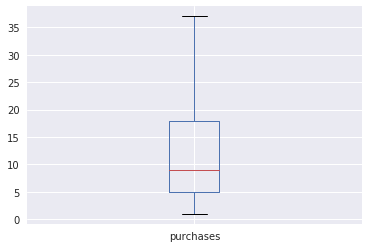

In [86]:
payers_distribution.boxplot(column='purchases', showfliers=False)
plt.show()

Since we have 6465820 of payments

With this query, we get that:
- 2585968 payed by whales ~40% payed by the 3% of the users
- 3135876 payed by dolphins ~ 50% payed by 45% of the users
- 743976 minnows ~ 10% payed by the 52% of the users
Which are benchmark numbers.



In [ ]:
%%capture

'''
```sql
select sum(purchases) 
from `king-ds-recruit-candidate-112.abtest.assignment` ag 
inner join 
(select playerid, sum(purchases) purchasesfrom `king-ds-recruit-candidate-112.abtest.activity` group by playerid) ac 
on ag.playerid=ac.playerid
```

```sql
select sum(purchases), type from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases,
case when sum(purchases)>100 then "whales" 
                        when sum(purchases) between 10 and 100 then "dolphin" 
                        when sum(purchases)<10 and sum(purchases)>0  then "minnows" 
                        when sum(purchases) = 0 then "NM" else "error" end as type
from `king-ds-recruit-candidate-112.abtest.activity` group by playerid) ac on ag.playerid=ac.playerid
group by type

```
'''

### Variables to check

After structure of the data we want to know, what should we analyze in the A/B test?
Well, we start for the question "how would we determine which of the experiences make Super Math Saga a better game?"
Is a game better if the ARPU is higher? or if the LTV is higher? or maybe in a game where the user play more hours per day or per month? 
Or if it has more whales? 

If there is no a major reason to analyze the behaviour of an specific KPI, the major number of experiments try to solve the next question:
*"How do I make more money?"*

Before that, I listed and checked some of the most important KPI's that may give some information about the case.

#### 1. Adquisition
1. [Num of registers](#Registers) - Not aplicable for A/B test in this scenario
2. [Retention](#Retention) (D1/D7)

#### 2. Activity
3. [DAU](#DAU)
4. [Days played by user](#Days_played_by_user)
5. [Gamerounds per day per user](#Gamerounds_per_day_per_user)

#### 3. Monetization
6. [Payers](#Payers)
7. [Purchases](#Purchases)
8. [Number of purchases per day per user](#Purchases_per_day_played)
9. [Number of purchases per day per gameend](#Purchases_per_gameend)
10. [ARPU](#ARPU)
11. [ARPPU](#ARPPU)

### Conclusions
12. [Final Conclusions](#Final_Conclusions)


#### Registers
We start analyzing the number of registers per day of the **New Users** during the Test vs the number of assignments. It shouldn't be any difference. Checking the plot below, there is no difference.

In [87]:
%%capture
%%bigquery n_registers
select PARSE_DATE('%Y-%m-%d', install_date) as install_date, count(1) n_of_users, sum(case when (install_date = assignment_date) then 1 else 0 end) as n_assignments
from `king-ds-recruit-candidate-112.abtest.assignment` where install_date >="2017-05-04"
group by install_date order by install_date asc

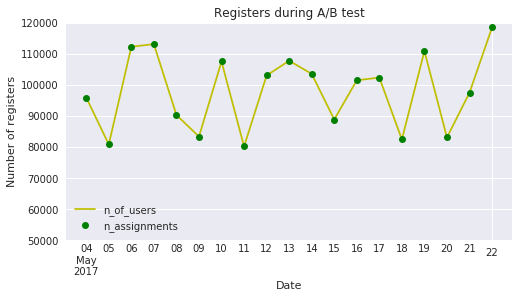

In [88]:
# Some date format transformation to plot
n_registers["install_date"] = pd.to_datetime(n_registers["install_date"], format='%Y-%m-%d')
n_registers.set_index(['install_date'],inplace=True)

# Plot
n_registers.plot(y=["n_of_users", "n_assignments"],style = ['y-','go'], kind='line', figsize=(8, 4))
plt.title('Registers during A/B test')
plt.ylabel('Number of registers')
plt.xlabel('Date')
plt.ylim(50000, 120000) 
plt.show()




The assignments and the installations are the same during the test phase, so let's check what happens between groups

In [89]:
%%capture
%%bigquery n_registers
select PARSE_DATE('%Y-%m-%d', install_date) as install_date, count(1) n_of_users, sum(case when (install_date = assignment_date) then 1 else 0 end) as n_assignments, abtest_group
from `king-ds-recruit-candidate-112.abtest.assignment` where install_date >="2017-05-04"
group by install_date, abtest_group order by install_date asc

In [90]:
n_registers.set_index(["install_date","abtest_group"], inplace= True)
n_registers =  n_registers.unstack("abtest_group")
n_registers.columns = ["_".join(x) for x in n_registers.columns.ravel()]

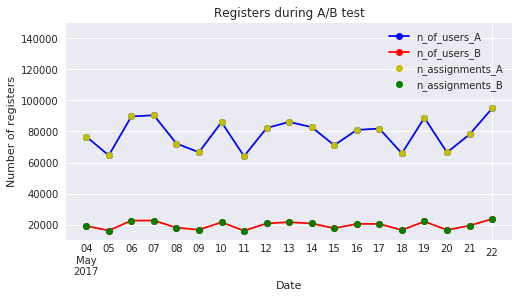

In [91]:
# Plot
styles=['b-','r-','yo','go']
n_registers.plot(y=["n_of_users_A", "n_of_users_B", "n_assignments_A", "n_assignments_B"],style=styles,marker ="o",  kind='line', figsize=(8, 4))
plt.title('Registers during A/B test')
plt.ylabel('Number of registers')
plt.xlabel('Date')
plt.ylim(10000, 150000) 
plt.show()

The difference we can check between groups is that the variance of the number of assigments is higher in the A group. And that is because we are dealing with higher numbers.
If the distribution of the assingments is completely random, there should not be any other difference.
Now we plot the number of registers with all the available data. We will need it later. As we can see, the number of registers increase during the TEST. A new campaign to find more users is a common practice for a TEST period.

In [92]:
%%capture
%%bigquery n_registers
select PARSE_DATE('%Y-%m-%d', install_date) as install_date, count(1) n_of_users, sum(case when (install_date = assignment_date) then 1 else 0 end) as n_assignments
from `king-ds-recruit-candidate-112.abtest.assignment` where install_date between "2017-04-20" and "2017-05-22"
group by install_date order by install_date asc

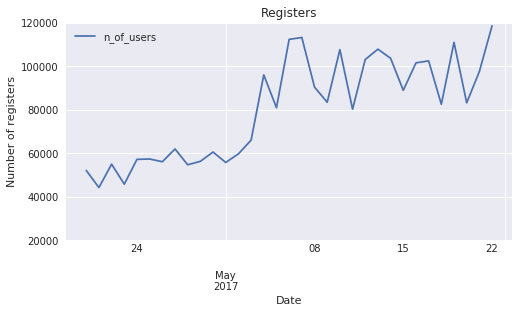

In [93]:
# Some date format transformation to plot
n_registers["install_date"] = pd.to_datetime(n_registers["install_date"], format='%Y-%m-%d')
n_registers.set_index(['install_date'],inplace=True)

# Plot
n_registers.plot(y="n_of_users",kind='line', figsize=(8, 4))
plt.title('Registers')
plt.ylabel('Number of registers')
plt.xlabel('Date')
plt.ylim(20000, 120000) 
plt.show()

The number of registers shouldn't give us information about the test. We calculated the percentatge of the users for every group and can't give any relevant information. 

Old Users (We only separate to understand better the distribution)

| All | All     | Whales | Dolphins | Minnows | 
|-----|---------|--------|----------|---------|
| A   | 6775568 | 6547   | 98620    | 94071   |
| B   | 1691920 | 1703   | 25082    | 22594   |
| A   | 80%     | 0.097% | 1.456%   | 1.388%  |
| B   | 20%     | 0.101% | 1.482%   | 1.335%  |

New Users 

| All | All     | Whales | Dolphins | Minnows |
|-----|---------|--------|----------|---------|
| A   | 1489764 | 203    | 3966     | 25760   |
| B   | 373170  | 53     | 1126     | 6421    |
| A   | 80.00%  | 0.014% | 0.266%   | 1.729%  |
| B   | 20.00%  | 0.014% | 0.302%   | 1.721%  |





In [ ]:
%%capture

'''
```sql
select count(1), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid from `king-ds-recruit-candidate-112.abtest.activity` group by playerid) ac on ag.playerid=ac.playerid where install_date< "2017-05-04" group by abtest_group;
```
```sql
select count(1), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid from `king-ds-recruit-candidate-112.abtest.activity` group by playerid) ac on ag.playerid=ac.playerid where install_date>= "2017-05-04" group by abtest_group;
```
```sql
select count(1),type, abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, case when sum(purchases)>100 then "whales" 
                        when sum(purchases) between 10 and 100 then "dolphin" 
                        when sum(purchases)<10 and sum(purchases)>0  then "minnows" 
                        when sum(purchases) = 0 then "NM" else "error" end as type
from `king-ds-recruit-candidate-112.abtest.activity` group by playerid) ac on ag.playerid=ac.playerid where install_date< "2017-05-04" group by type,abtest_group;
```
```sql
select count(1),type, abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, case when sum(purchases)>100 then "whales" 
                        when sum(purchases) between 10 and 100 then "dolphin" 
                        when sum(purchases)<10 and sum(purchases)>0  then "minnows" 
                        when sum(purchases) = 0 then "NM" else "error" end as type
from `king-ds-recruit-candidate-112.abtest.activity` group by playerid) ac on ag.playerid=ac.playerid where install_date>= "2017-05-04" group by type,abtest_group;
```
'''

#### Retention

I have found that the retention D1 for the new users drops(from arround 75% to 55%, first figure vs second figure).  This is probably because the source of users changed, in order to register more users in less time, therefore the quality of the leed use to be lower.


In [ ]:
%%capture
'''
```sql
select A.install_date, 100*A.n/B.total D1_retention from (
select count(1) n, max(PARSE_DATE('%Y-%m-%d', install_date)) install_date   FROM `king-ds-recruit-candidate-112.abtest.activity` a inner JOIN `king-ds-recruit-candidate-112.abtest.assignment` b 
on a.playerid = b.playerid and DATE_ADD(PARSE_DATE('%Y-%m-%d', install_date), INTERVAL 1 DAY) =PARSE_DATE('%Y-%m-%d',a.activity_date) group by PARSE_DATE('%Y-%m-%d', install_date)
having install_date < '2017-05-04')A
inner join 
(select count(1) total, max(PARSE_DATE('%Y-%m-%d', install_date)) install_date FROM `king-ds-recruit-candidate-112.abtest.assignment`  group by PARSE_DATE('%Y-%m-%d', install_date) having install_date < '2017-05-04' 
)B on A.install_date = B.install_date;
```

```sql
select A.install_date, 100*A.n/B.total D1_retention, A.abtest_group from (
select count(1) n, max(PARSE_DATE('%Y-%m-%d', install_date)) install_date, abtest_group   FROM `king-ds-recruit-candidate-112.abtest.activity` a inner JOIN `king-ds-recruit-candidate-112.abtest.assignment` b 
on a.playerid = b.playerid and DATE_ADD(PARSE_DATE('%Y-%m-%d', install_date), INTERVAL 1 DAY) =PARSE_DATE('%Y-%m-%d',a.activity_date) group by PARSE_DATE('%Y-%m-%d', install_date), abtest_group
having install_date >= '2017-05-04')A
inner join 
(select count(1) total, max(PARSE_DATE('%Y-%m-%d', install_date)) install_date, abtest_group FROM `king-ds-recruit-candidate-112.abtest.assignment`  group by PARSE_DATE('%Y-%m-%d', install_date), abtest_group having install_date >= '2017-05-04' 
)B on A.d = B.d and A.abtest_group =B.abtest_group 
```
'''

In [127]:
%%capture
%%bigquery d1_retention_old_users
select A.install_date, 100*A.n/B.total d1_retention from (
select count(1) n, max(PARSE_DATE('%Y-%m-%d', install_date)) install_date   FROM `king-ds-recruit-candidate-112.abtest.activity` a inner JOIN `king-ds-recruit-candidate-112.abtest.assignment` b 
on a.playerid = b.playerid and DATE_ADD(PARSE_DATE('%Y-%m-%d', install_date), INTERVAL 7 DAY) =PARSE_DATE('%Y-%m-%d',a.activity_date) group by PARSE_DATE('%Y-%m-%d', install_date)
having install_date < '2017-05-04')A
inner join 
(select count(1) total, max(PARSE_DATE('%Y-%m-%d', install_date)) install_date FROM `king-ds-recruit-candidate-112.abtest.assignment`  group by PARSE_DATE('%Y-%m-%d', install_date) having install_date < '2017-05-04' 
)B on A.install_date = B.install_date;

In [128]:
%%capture
%%bigquery d1_retention_new_users
select A.install_date, 100*A.n/B.total d1_retention, A.abtest_group from (
select count(1) n, max(PARSE_DATE('%Y-%m-%d', install_date)) install_date, abtest_group   FROM `king-ds-recruit-candidate-112.abtest.activity` a inner JOIN `king-ds-recruit-candidate-112.abtest.assignment` b 
on a.playerid = b.playerid and DATE_ADD(PARSE_DATE('%Y-%m-%d', install_date), INTERVAL 1 DAY) =PARSE_DATE('%Y-%m-%d',a.activity_date) group by PARSE_DATE('%Y-%m-%d', install_date), abtest_group
having install_date >= '2017-05-04')A
inner join 
(select count(1) total, max(PARSE_DATE('%Y-%m-%d', install_date)) install_date, abtest_group FROM `king-ds-recruit-candidate-112.abtest.assignment`  group by PARSE_DATE('%Y-%m-%d', install_date), abtest_group having install_date >= '2017-05-04' 
)B on A.install_date = B.install_date and A.abtest_group =B.abtest_group 

In [129]:
d1_retention_old_users.set_index(["install_date"], inplace= True)

d1_retention_new_users.set_index(["install_date","abtest_group"], inplace= True)
d1_retention_new_users =  d1_retention_new_users.unstack("abtest_group")



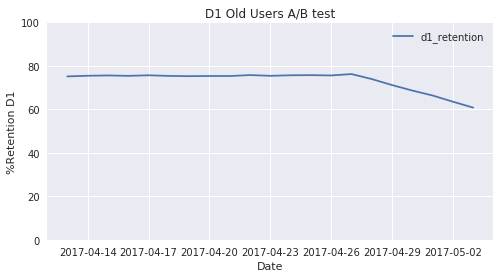

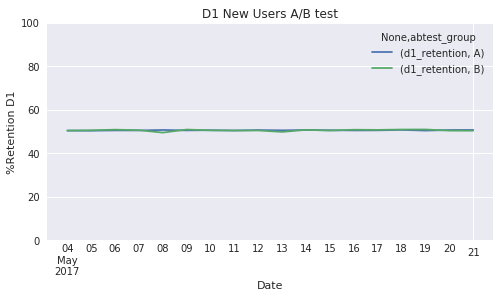

In [130]:

# Plot
d1_retention_old_users.plot(kind='line', figsize=(8, 4))
plt.title('D1 Old Users A/B test')
plt.ylabel('%Retention D1')
plt.xlabel('Date')
plt.ylim(0,100)

d1_retention_new_users.plot(kind='line', figsize=(8, 4))
plt.title('D1 New Users A/B test')
plt.ylabel('%Retention D1')
plt.xlabel('Date')
plt.ylim(0,100) 
plt.show()

#### DAU

We check if there is any difference in the active users for the different TEST groups. With the plot below we could thing that there is something that does not fit. After further analisys, we check that the DAU for the control and test group is divided in 80% and 20% of the sample during all the TEST.

In [149]:
%%capture
%%bigquery DAU
select PARSE_DATE('%Y-%m-%d', activity_date) activity_date, count(distinct ag.playerid) active_users,  abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, activity_date from `king-ds-recruit-candidate-112.abtest.activity` group by playerid, activity_date ) ac on ag.playerid=ac.playerid  where install_date >= "2017-05-04" group by  activity_date, abtest_group
order by 2 asc;

In [150]:
DAU.set_index(["activity_date","abtest_group"], inplace= True)
DAU =  DAU.unstack("abtest_group")
DAU.columns = ["_".join(x) for x in DAU.columns.ravel()]

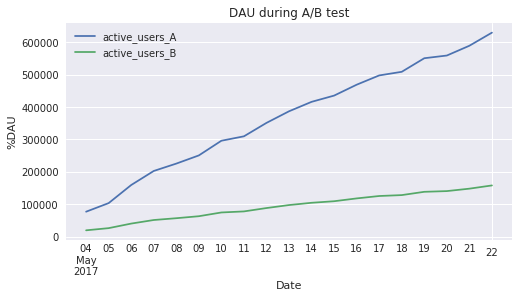

In [151]:
# Plot
DAU.plot(kind='line', figsize=(8, 4))
plt.title('DAU during A/B test')
plt.ylabel('%DAU')
plt.xlabel('Date')
plt.show()

#### Days played by user <a id='Days_played_by_user'></a>

We have seen if there is a difference in the distribution for the A/B users. The first boxplot is for the New Users, and the second is for the Old Users. We can't appreciate any reliable difference.

In [152]:
%%capture
%%bigquery played_days_per_new_user
select sum(n_days_played) as n_days_played, abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select count(1) n_days_played, playerid from `king-ds-recruit-candidate-112.abtest.activity` where activity_date >="2017-05-04" group by playerid) ac on ag.playerid=ac.playerid where install_date>= "2017-05-04"  group by ac.playerid,abtest_group


In [161]:
A = played_days_per_new_user[played_days_per_new_user["abtest_group"]=="A"].n_days_played
B = played_days_per_new_user[played_days_per_new_user["abtest_group"]=="B"].n_days_played

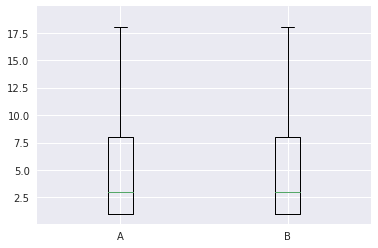

In [164]:
fig, ax = plt.subplots()
ax.boxplot([A,B])
ax.set_xticklabels(["A","B"])

plt.show()

In [168]:
%%capture
%%bigquery played_days_per_old_user
select sum(n_days_played) as n_days_played, abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select count(1) n_days_played, playerid from `king-ds-recruit-candidate-112.abtest.activity` where activity_date >="2017-05-04" group by playerid) ac on ag.playerid=ac.playerid where install_date< "2017-05-04"  group by ac.playerid,abtest_group


In [169]:
A = played_days_per_old_user[played_days_per_old_user["abtest_group"]=="A"].n_days_played
B = played_days_per_old_user[played_days_per_old_user["abtest_group"]=="B"].n_days_played

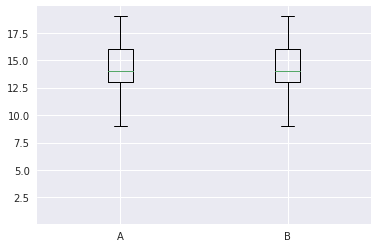

In [170]:
fig, ax = plt.subplots()
ax.boxplot([A,B])
ax.set_xticklabels(["A","B"])

plt.show()

#### Gamerounds per day per user <a id='Gamerounds_per_day_per_user'></a>

Calculating the number of games per user for every day playing we find this. It might give us information about what happens to the oldest users during the TEST against the Newest Players.

| All | Old Players | New Players |
|-----|-------------|-------------|
| A   | 13.18       | 12.985      |
| B   | 12.941      | 13.194      |

We check the distribution of the games per player and try to find if there is a difference between them. To do so, we have normalized the values, and applied a T-Student Test. We can't confidently say that they are different from group A to group B.


In [231]:
%%capture
'''
```sql
select sum(gameends)/SUM(n_days), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(gameends) gameends, count(1) n_days from `king-ds-recruit-candidate-112.abtest.activity` where activity_date >="2017-05-04" group by playerid
) ac on ag.playerid=ac.playerid where  install_date< "2017-05-04" group by abtest_group;
```
'''

In [325]:
%%capture
%%bigquery gameends_per_user 
select sum(gameends) gameends, abtest_group, ac.playerid  from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(gameends) gameends from `king-ds-recruit-candidate-112.abtest.activity`  where activity_date >="2017-05-04"  group by playerid
) ac on ag.playerid=ac.playerid where  install_date>= "2017-05-04" group by abtest_group, ac.playerid


In [326]:
# p =gameends_per_user.copy() 
gameends_per_user = p.copy()

In [327]:
gameends_per_user.set_index(["playerid","abtest_group"], inplace= True)
gameends_per_user =  gameends_per_user.unstack("abtest_group")
gameends_per_user.columns = ["_".join(x) for x in gameends_per_user.columns.ravel()]
gameends_A= gameends_per_user["gameends_A"].value_counts().to_frame().sort_index()
gameends_B= gameends_per_user["gameends_B"].value_counts().to_frame().sort_index()
gameends_per_user = pd.concat([gameends_A, gameends_B], axis=1, join_axes=[gameends_A.index]).fillna(0)
gameends_per_user = minmax_scaling(gameends_per_user, columns = list(gameends_per_user.columns))


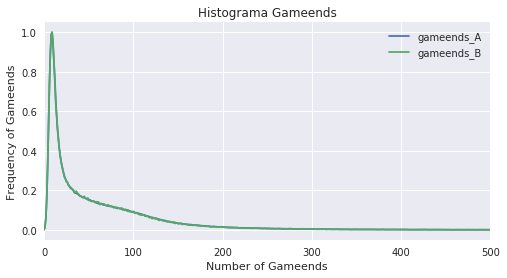

In [333]:
# Plot
gameends_per_user.plot(kind='line', figsize=(8, 4), xlim=(0,500))

plt.title('Histograma Gameends')
plt.ylabel('Frequency of Gameends')
plt.xlabel('Number of Gameends')
plt.show()

In [349]:
# gameends_per_user.shape

ttest = stats.ttest_ind(gameends_per_user.gameends_A, gameends_per_user.gameends_B)
ttest

Ttest_indResult(statistic=0.028800982932218944, pvalue=0.9770254677919907)

In [335]:
mean_A = gameends_per_user.gameends_A.mean()
mean_B = gameends_per_user.gameends_B.mean()
mean_A-mean_B

In [351]:

# Run independent t-test
ind_t_test = stats.ttest_ind(gameends_per_user.gameends_A, gameends_per_user.gameends_B)

# Calculate the mean difference and 95% confidence interval
N1 = 1337
N2 = 1337
df = (N1 + N2 - 2)
std1 = gameends_per_user.gameends_A.std()
std2 = gameends_per_user.gameends_B.std()
std_N1N2 = sqrt( ((N1 - 1)*(std1)**2 + (N2 - 1)*(std2)**2) / df) 

diff_mean = gameends_per_user.gameends_A.mean() - gameends_per_user.gameends_B.mean()
MoE = stats.t.ppf(0.975, df) * std_N1N2 * sqrt(1/N1 + 1/N2)

print('The results of the independent t-test are: \n\tt-value = {:4.3f}\n\tp-value = {:4.3f}'.format(ind_t_test[0],ind_t_test[1]))
print ('\nThe difference between groups is {:3.5f} [{:3.5f} to {:3.5f}] (mean [95% CI])'.format(diff_mean, diff_mean - MoE, diff_mean + MoE))

The results of the independent t-test are: 
	t-value = 0.029
	p-value = 0.977

The difference between groups is 0.00009 [-0.00624 to 0.00642] (mean [95% CI])


We also have studied the distribution for oldest users.

In [301]:
%%capture
%%bigquery gameends_per_user_old
select sum(gameends) gameends, abtest_group, ac.playerid  from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(gameends) gameends from `king-ds-recruit-candidate-112.abtest.activity`  where activity_date >="2017-05-04"  group by playerid
) ac on ag.playerid=ac.playerid where  install_date< "2017-05-04" group by abtest_group, ac.playerid

In [302]:
gameends_per_user_old.set_index(["playerid","abtest_group"], inplace= True)
gameends_per_user_old =  gameends_per_user_old.unstack("abtest_group")
gameends_per_user_old.columns = ["_".join(x) for x in gameends_per_user_old.columns.ravel()]
gameends_A= gameends_per_user_old["gameends_A"].value_counts().to_frame().sort_index()
gameends_B= gameends_per_user_old["gameends_B"].value_counts().to_frame().sort_index()
gameends_per_user_old = pd.concat([gameends_A, gameends_B], axis=1, join_axes=[gameends_A.index])

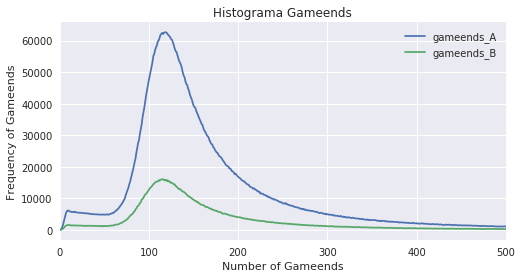

In [305]:
# Plot
gameends_per_user_old.plot(kind='line', figsize=(8, 4), xlim=(0,500))

plt.title('Histograma Gameends')
plt.ylabel('Frequency of Gameends')
plt.xlabel('Number of Gameends')
plt.show()

#### Payers
As we checked before, there is not a big difference between the amount of payers in for the groups in the New Users.
We check now the number of payers against the total register. And also the number of days until the first payment.

| All | All     | Payers | %     |
|-----|---------|--------|-------|
| A   | 1489764 | 29929  | 2.008 |
| B   | 373170  | 7600   | 2.036 |

* Avg num of days until first payment for new users group A: 1.239
* Avg num of days until first payment for new users group B: 1.183 


In [228]:
%%capture
'''
```sql
select count(1), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases from `king-ds-recruit-candidate-112.abtest.activity` group by playerid) ac on ag.playerid=ac.playerid 
where  install_date>= "2017-05-04"
group by abtest_group;
```

```sql 
select AVG(DATE_DIFF(PARSE_DATE('%Y-%m-%d', conversion_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY)) days_conversion, abtest_group
from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid from `king-ds-recruit-candidate-112.abtest.activity` group by playerid) ac on ag.playerid=ac.playerid  where conversion_date is not null and  install_date>= "2017-05-04" group by abtest_group 
```
'''

#### Purchases

We check the boxplot of the purchases for every group, so seek any difference. But we need more information. We will study the purchases per days played and per gameends played.

In [179]:
%%capture
%%bigquery payed
select sum(purchases) purchases,ac.playerid, abtest_group  from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases from `king-ds-recruit-candidate-112.abtest.activity` where activity_date >= "2017-05-04" and purchases >0 group by playerid) ac on ag.playerid=ac.playerid 
where install_date>= "2017-05-04"
group by abtest_group, ac.playerid;

In [180]:
payed.set_index(["playerid","abtest_group"], inplace= True)
payed =  payed.unstack("abtest_group")
payed.columns = ["_".join(x) for x in payed.columns.ravel()]


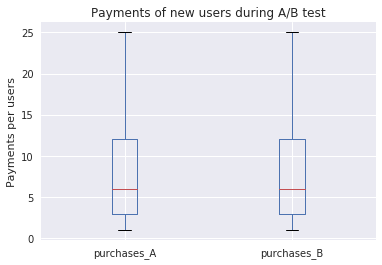

In [181]:
# fig, ax = plt.subplots()
# ax.boxplot(payed,showfliers=False )
payed.boxplot(column=['purchases_A', 'purchases_B'], showfliers=False)
plt.title('Purchases of new users during A/B test')
plt.ylabel('Payments per user')
plt.show()


#### Purchases per day played <a id='Purchases_per_day_played'></a>


This metric is similiar to a ARPU. But instead of the avg revenue(we can only assume now that every purchase has the same value) we calculate the number of purchases, and instead of having a period of time, we use the number of days played by the users.
We find in the next table, that something might be hapening.

| All | Old Players | New Players |
|-----|-------------|-------------|
| A   | 2.528       | 2.56        |
| B   | 2.55        | 2.597       |



But lets check this data more carefully: lets see the number of payments for every day for the first days for the New Users.

As we can see, the number of purchases per day is higher for the B group than for the A group.

In [ ]:
'''
```sql
select sum(purchases)/SUM(n_days), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases, count(1) n_days from `king-ds-recruit-candidate-112.abtest.activity`  where purchases >0 and activity_date >="2017-05-04" group by playerid
) ac on ag.playerid=ac.playerid where  install_date< "2017-05-04" group by abtest_group;
```

```sql
select sum(purchases)/SUM(n_days), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases, count(1) n_days from `king-ds-recruit-candidate-112.abtest.activity`  where purchases >0 and activity_date >="2017-05-04" group by playerid
) ac on ag.playerid=ac.playerid where  install_date>= "2017-05-04" group by abtest_group;
```
'''

In [204]:
%%capture
%%bigquery purchase_per_user_day 
select 
case when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =0 then "0"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =1 then "1"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =2 then "2"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =3 then "3"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =4 then "4"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =5 then "5"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =6 then "6" 
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =7 then "7" 
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =8 then "8" 
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =9 then "9" 

else ">9" end as day,
sum(purchases) purchases,count(ac.playerid) n_players, sum(purchases)/count(ac.playerid) purchase_per_player, abtest_group
from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, purchases, activity_date from `king-ds-recruit-candidate-112.abtest.activity` where activity_date >="2017-05-04" 
) ac on ag.playerid=ac.playerid where  install_date>= "2017-05-04" group by 1, abtest_group order by 1 asc, abtest_group;

In [205]:
purchase_per_user_day.set_index(["day","abtest_group"], inplace= True)
purchase_per_user_day =  purchase_per_user_day.unstack("purchase_per_user_day.columns.ravel()]

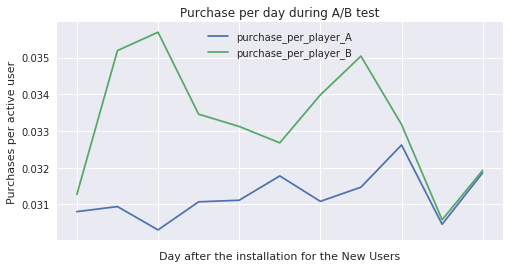

In [206]:
# Plot
purchase_per_user_day.plot( y = ["purchase_per_player_A","purchase_per_player_B"], kind='line', figsize=(8, 4))
plt.title('Purchase per day during A/B test')
plt.ylabel('Purchases per active user')
plt.xlabel('Day after the installation for the New Users')
plt.show()

In [210]:
%%capture
%%bigquery purchase_per_payeruser_day 
select 
case when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =0 then "0"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =1 then "1"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =2 then "2"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =3 then "3"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =4 then "4"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =5 then "5"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =6 then "6" 
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =7 then "7" 
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =8 then "8" 
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =9 then "9" 
else ">9" end as day,
sum(purchases) purchases,count(ac.playerid) n_players, sum(purchases)/count(ac.playerid) purchase_per_payer_user, abtest_group
from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, purchases, activity_date from `king-ds-recruit-candidate-112.abtest.activity` where activity_date >="2017-05-04" and purchases>0
) ac on ag.playerid=ac.playerid where  install_date>= "2017-05-04" group by 1, abtest_group order by 1 asc, abtest_group;

In [211]:
purchase_per_payeruser_day.set_index(["day","abtest_group"], inplace= True)
purchase_per_payeruser_day =  purchase_per_payeruser_day.unstack("abtest_group")
purchase_per_payeruser_day.columns = ["_".join(x) for x in purchase_per_payeruser_day.columns.ravel()]

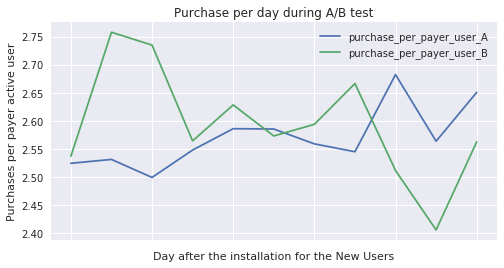

In [212]:
# Plot
purchase_per_payeruser_day.plot( y = ["purchase_per_payer_user_A","purchase_per_payer_user_B"], kind='line', figsize=(8, 4))
plt.title('Purchase per day during A/B test')
plt.ylabel('Purchases per payer active user')
plt.xlabel('Day after the installation for the New Users')
plt.show()

#### Purchases per gameends played <a id='Purchases_per_gameend'></a>

So it seems, that the first days the active users on the group B are paying more times than in the group A. To confirm what is going on, lets check the payments per number of games played

In [214]:
%%capture
%%bigquery purchases_per_gameends 
select 
case when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =0 then "0"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =1 then "1"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =2 then "2"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =3 then "3"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =4 then "4"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =5 then "5"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =6 then "6"
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =7 then "7" 
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =8 then "8" 
when DATE_DIFF(PARSE_DATE('%Y-%m-%d', activity_date), PARSE_DATE ('%Y-%m-%d', install_date), DAY) =9 then "9" 
else ">9" end as day,
sum(gameends) gameends , sum(purchases)/sum(gameends) purchases_per_gameends, abtest_group
from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, gameends,purchases, activity_date from `king-ds-recruit-candidate-112.abtest.activity` where activity_date >="2017-05-04" 
) ac on ag.playerid=ac.playerid where  install_date>= "2017-05-04" group by 1, abtest_group order by 1 asc, abtest_group;

In [215]:
purchases_per_gameends.set_index(["day","abtest_group"], inplace= True)
purchases_per_gameends =  purchases_per_gameends.unstack("abtest_group")
purchases_per_gameends.columns = ["_".join(x) for x in purchases_per_gameends.columns.ravel()]

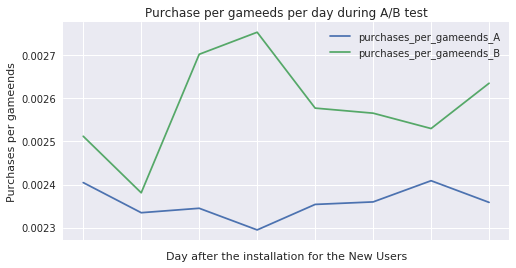

In [216]:
# Plot
purchases_per_gameends.plot( y = ["purchases_per_gameends_A","purchases_per_gameends_B"], kind='line', figsize=(8, 4))
plt.title('Purchase per gameeds per day during A/B test')
plt.ylabel('Purchases per gameends')
plt.xlabel('Day after the installation for the New Users')
plt.show()

#### ARPU
Let's calculate something like ARPU (since we dont have the amounts of the purchases, and we assumed each purchase = 1).

| ARPU | Old Players | New Players |
|------|-------------|-------------|
| A    | 0.419       | 0.146       |
| B    | 0.434       | 0.155       |



In [ ]:
%%capture
'''
```sql
select sum(purchases)/count(ac.playerid), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases from `king-ds-recruit-candidate-112.abtest.activity`  where activity_date >="2017-05-04" group by playerid
) ac on ag.playerid=ac.playerid where  install_date>= "2017-05-04" group by abtest_group;
```
```sql
select sum(purchases)/count(ac.playerid), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases from `king-ds-recruit-candidate-112.abtest.activity`  where activity_date >="2017-05-04" group by playerid
) ac on ag.playerid=ac.playerid where  install_date< "2017-05-04" group by abtest_group;
```
'''

#### ARPPU

|ARPPU | Old Players | New Players |
|------|-------------|-------------|
| A    | 14.68       | 7.31        |
| B    | 15.30       | 7.65        |


And more specific

| -   | Old Players |     -    |     -   | New Players |    -     |    -    |
|-----|-------------|----------|---------|-------------|----------|---------|
|  -  | Whales      | Dolphins | Minnows | Whales      | Dolphins | Minnows |
| A   | 280.18      | 22.92    | 4.45    | 270.2       | 22.36    | 2.92    |
| B   | 266.8       | 23.20    | 4.55    | 270.35      | 21.84    | 2.99    |



In [352]:
%%capture
'''
```sql
select sum(purchases)/count(ac.playerid), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases from `king-ds-recruit-candidate-112.abtest.activity`  where activity_date >="2017-05-04" and purchases>0 group by playerid
) ac on ag.playerid=ac.playerid where  install_date>= "2017-05-04" group by abtest_group;
```
```sql
select sum(purchases)/count(ac.playerid), abtest_group from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases from `king-ds-recruit-candidate-112.abtest.activity`  where activity_date >="2017-05-04" and purchases>0 group by playerid
) ac on ag.playerid=ac.playerid where  install_date< "2017-05-04" group by abtest_group;
```

```sql
select sum(purchases)/count(ac.playerid), abtest_group, type from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases, case when sum(purchases)>100 then "whales" 
                        when sum(purchases) between 10 and 100 then "dolphin" 
                        when sum(purchases)<10 and sum(purchases)>0  then "minnows" 
                        when sum(purchases) = 0 then "NM" else "error" end as type from `king-ds-recruit-candidate-112.abtest.activity`  where activity_date >="2017-05-04" and purchases>0 group by playerid
) ac on ag.playerid=ac.playerid where  install_date>= "2017-05-04" group by abtest_group, type;
```
```sql
select sum(purchases)/count(ac.playerid), abtest_group, type from `king-ds-recruit-candidate-112.abtest.assignment` ag inner join 
(select playerid, sum(purchases) purchases, case when sum(purchases)>100 then "whales" 
                        when sum(purchases) between 10 and 100 then "dolphin" 
                        when sum(purchases)<10 and sum(purchases)>0  then "minnows" 
                        when sum(purchases) = 0 then "NM" else "error" end as type from `king-ds-recruit-candidate-112.abtest.activity`  where activity_date >="2017-05-04" and purchases>0 group by playerid
) ac on ag.playerid=ac.playerid where  install_date< "2017-05-04" group by abtest_group, type;
```
'''

### Final Conclusions <a id='Final_Conclusions'></a>

Studying this case I think that the Adquistion and Activity Kpi's are not tested. By the way the experiment is explained and the data is given, the Adquisition is not case of study. Also, the Activity of the users, by the active days, or the number of gameend played by them, doesn't seem a kpi to study in this case.
So we go back to the question, "how do we do more money?". There are some ways to do that: getting more users, increasing the revenue from the already payer users (increasing  whales', dolphins' or minnows' number of purchases), increasing the avg ticket, or increasing the ratio payers againts non-payers.
Of all of that, I think that the test changed something to make the users pay more easier. So, the conversion to pay is easiest. Maybe a timed-sale. After the first payment, the users are more likely to pay again.
For the question "What other aspects do you think would be valuable to consider for analysing an A/B test?"
I think the avg purchase would be great to analyze. Also, the differences during week vs weekends.

